<img src="./img/Logo.png" align="right" width="50%"></img>
# MissionAtlantic GeoNode Workshop
### Tier 2: How to use OGC webservices offered by the MissionAtlantic GeoNode in your data analysis

## 3. Subset & download data using OGC Web Feature and Coverage Services (WFS/WCS)

The OWSLib library is a python library that makes accessing data and metadata through OGC services possible. The library abstracts all of the traditional HTTP API calls into programmatic function calls. We will be using this library throughout the tutorial to interact with the MissionAtlantic GeoNode OGC services.

The library is available from GitHub @  https://github.com/geopython/OWSLib

In [113]:
from owslib.wfs import WebFeatureService
from owslib.wcs import WebCoverageService
from matplotlib import pyplot as plt

### 3.1 Get vector data with WFS

#### Create a WebFeatureService (WFS) object
Note that we use version 1.1.0 as in OWSLib this version has support for [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [114]:
wfs = WebFeatureService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.1.0')

#### Find out what the WFS has to offer. Service metadata:

In [115]:
print(wfs.identification.type)
print(wfs.identification.version)
print(wfs.identification.title)
print(wfs.identification.abstract)

WFS
1.1.0
Mission Atlantic GeoNode WFS service
This is the WFS service of the Mission Atlantic GeoNode


#### See available methods

In [116]:
[operation.name for operation in wfs.operations]

['GetCapabilities',
 'DescribeFeatureType',
 'GetFeature',
 'GetGmlObject',
 'LockFeature',
 'GetFeatureWithLock',
 'Transaction']

#### Get available formats

In [117]:
wfs.getOperationByName('GetFeature').parameters

{'resultType': {'values': ['results', 'hits']},
 'outputFormat': {'values': ['text/xml; subtype=gml/3.1.1',
   'GML2',
   'KML',
   'SHAPE-ZIP',
   'application/gml+xml; version=3.2',
   'application/json',
   'application/vnd.google-earth.kml xml',
   'application/vnd.google-earth.kml+xml',
   'application/x-gpkg',
   'csv',
   'excel',
   'excel2007',
   'geopackage',
   'geopkg',
   'gml3',
   'gml32',
   'gpkg',
   'json',
   'text/csv',
   'text/javascript',
   'text/xml; subtype=gml/2.1.2',
   'text/xml; subtype=gml/3.2']}}

#### Find out what vector datasets (FeatureTypes) are available
Note that only vector datasets that are uploaded to the GeoNode and are publicly available are shown

In [118]:
list(wfs.contents)

['geonode:Wind_Farms_EMODnet']

In [119]:
# Select the desired dataset among the list returned above
dataset = 'geonode:Wind_Farms_EMODnet'

#### Get the FeatureType metadata:

In [120]:
print(wfs.contents[dataset].title)
print(wfs.contents[dataset].abstract)
bbox1 = wfs.contents[dataset].boundingBoxWGS84
print (bbox1)

EMODnet, Human Activities, Energy, Wind Farms
The database on offshore wind farms in the EU was created in 2014 by CETMAR for the European Marine Observation and Data Network (EMODnet). It is the result of the aggregation and harmonization of datasets provided by several sources. It is updated every year and is available for viewing and download on EMODnet Human Activities web portal (https://emodnet.ec.europa.eu/en/human-activities). The database contains points and/or (where available) polygons representing offshore wind farms in the following countries: Belgium, Denmark, Estonia, Finland, France, Germany, Greece, Ireland, Italy, Latvia, Lithuania, Netherlands, Norway, Poland, Portugal, Spain, Sweden and United Kingdom. Each point has the following attributes (where available): Name, Nº of turbines, Status (Approved, Planned, Dismantled, Construction, Production, Test site), Country, Year, Power (MW), Distance to coast (metres) and Area (square kilometres). The distance to coast (EEA

#### Get the FeatureType’s schema via `DescribeFeatureType`.
The dictionary returned is compatible with a [Fiona schema object](https://fiona.readthedocs.io/en/latest/fiona.html#fiona.collection.Collection.schema).

In [121]:
wfs.get_schema(dataset)

{'properties': {'fid': 'int',
  'country': 'string',
  'n_turbines': 'long',
  'power_mw': 'double',
  'status': 'string',
  'year': 'string',
  'dist_coast': 'double',
  'area_sqkm': 'double',
  'notes': 'string'},
 'required': ['fid'],
 'geometry': '3D MultiPolygon',
 'geometry_column': 'the_geom'}

#### Subset data with a bounding box

In [122]:
# Subset data with a bounding box
response = wfs.getfeature(typename=dataset,
                          bbox=(bbox1), #subset to the Study area ( based on bbox params)
                          outputFormat='application/json')

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
import geopandas as gpd
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}.json')
gdf

,id,fid,country,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,Wind_Farms_EMODnet.1,1,Sweden,108.0,864.0,Planned,,24805.731113,59.826131,,"MULTIPOLYGON (((12.03532 56.65295, 12.06134 56..."
1,Wind_Farms_EMODnet.2,2,Sweden,5.0,11.5,Production,,0.000000,0.193854,,"MULTIPOLYGON (((12.46710 56.89015, 12.47244 56..."
2,Wind_Farms_EMODnet.3,3,Sweden,50.0,282.0,Approved,,6381.649369,22.111037,,"MULTIPOLYGON (((12.33361 56.86036, 12.34738 56..."
3,Wind_Farms_EMODnet.4,4,United Kingdom,10.0,10.0,Planned,,45.484159,4.756627,,"MULTIPOLYGON (((-6.48391 58.43840, -6.45466 58..."
4,Wind_Farms_EMODnet.5,5,United Kingdom,10.0,10.0,Approved,,1122.942248,27.611537,,"MULTIPOLYGON (((-6.52572 55.65146, -6.55948 55..."
...,...,...,...,...,...,...,...,...,...,...,...
526,Wind_Farms_EMODnet.527,527,Spain,NaN,NaN,Planned,,6352.036015,164.014429,,"MULTIPOLYGON (((-15.22104 27.87453, -15.22323 ..."
527,Wind_Farms_EMODnet.528,528,Estonia,NaN,NaN,Planned,,10936.264024,475.437637,,"MULTIPOLYGON (((22.87573 57.88582, 22.83318 57..."
528,Wind_Farms_EMODnet.529,529,Estonia,NaN,NaN,Planned,,9903.634178,1217.896092,,"MULTIPOLYGON (((21.69848 57.84691, 21.65391 57..."
529,Wind_Farms_EMODnet.530,530,Estonia,NaN,NaN,Planned,,53078.632060,87.964217,,"MULTIPOLYGON (((20.79879 58.23678, 20.89771 58..."


C:\Users\matteo.mikos\AppData\Local\Temp\ipykernel_10556\2282531803.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(33.0, 65.0)

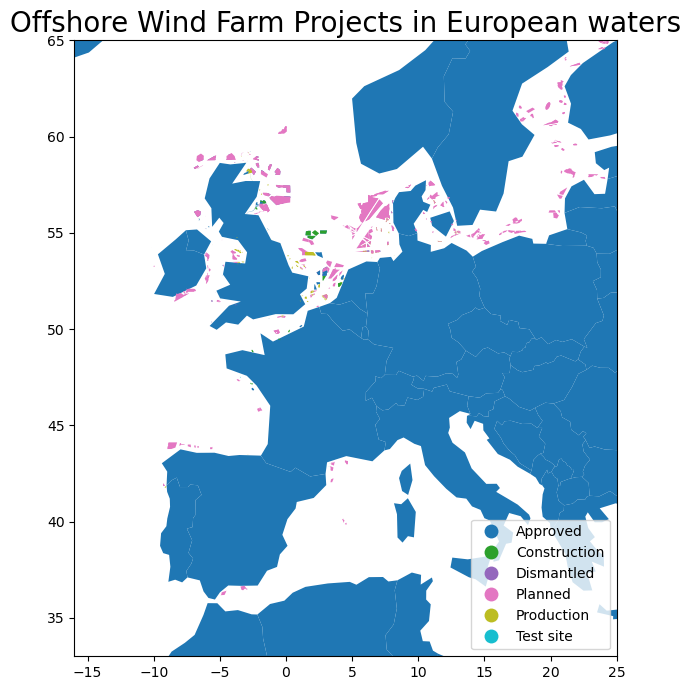

In [123]:
# Get shapefile of world outline
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, figsize=(9,8))
world.plot(ax=ax) # add world as base layer
gdf.plot(column='status',
         categorical=False,
         cmap='tab10',
         legend= True,
         legend_kwds={'loc': 'lower right'},
         alpha = 1,
         ax=ax) # Add study areas colored by study region number
ax.set_title('Offshore Wind Farm Projects in European waters',fontsize=20)

#Set the map limits based on the bbox params to zoom in on your dataset
ax.set_xlim(-16,25) 
ax.set_ylim(33,65)

#### Subset data by attributes using [OGC Filter Encoding](https://www.ogc.org/standards/filter)

In [124]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
sa_filter = fes.PropertyIsEqualTo(propertyname='status', literal='Planned') # Planned Windfarm projects
fid_filter = fes.PropertyIsBetween(propertyname='area_sqkm', lower = 1000, upper= 100000) # filter for projects bigger than 1000Km²
filter = fes.And([sa_filter,fid_filter]) # combine both filtering parameters using "AND"

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs.getfeature(typename=dataset,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{dataset.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{dataset.replace(":","_")}_filtered.json')
gdf

,id,fid,country,n_turbines,power_mw,status,year,dist_coast,area_sqkm,notes,geometry
0,Wind_Farms_EMODnet.40,40,Denmark,NaN,NaN,Planned,,49194.172947,1872.941410,,"MULTIPOLYGON (((6.41926 55.80585, 6.41538 55.8..."
1,Wind_Farms_EMODnet.48,48,Denmark,NaN,NaN,Planned,,19964.419331,3176.148975,,"MULTIPOLYGON (((7.79172 56.37805, 7.79165 56.3..."
2,Wind_Farms_EMODnet.36,36,Denmark,NaN,NaN,Planned,,109379.688310,4484.323143,,"MULTIPOLYGON (((6.33084 56.44456, 6.32952 56.4..."
3,Wind_Farms_EMODnet.44,44,Denmark,NaN,NaN,Planned,,73863.316263,1642.587692,,"MULTIPOLYGON (((6.51131 56.88091, 6.54150 56.8..."
4,Wind_Farms_EMODnet.81,81,Netherlands,NaN,4000.0,Planned,,49466.898142,1172.060155,,"MULTIPOLYGON (((3.74863 53.16913, 3.74864 53.0..."
5,Wind_Farms_EMODnet.133,133,Ireland,NaN,NaN,Planned,,0.000000,1009.408557,,"MULTIPOLYGON (((-7.49680 52.06100, -7.49660 52..."
6,Wind_Farms_EMODnet.294,294,United Kingdom,NaN,NaN,Planned,2020,9457.333545,1106.354044,,"MULTIPOLYGON (((-6.32441 59.05853, -6.31226 59..."
7,Wind_Farms_EMODnet.295,295,United Kingdom,NaN,NaN,Planned,2020,3171.943570,1162.427300,,"MULTIPOLYGON (((-4.10739 59.13575, -4.09759 59..."
8,Wind_Farms_EMODnet.297,297,United Kingdom,NaN,NaN,Planned,2020,59706.165817,1291.429348,,"MULTIPOLYGON (((-0.50129 57.47805, -0.48542 57..."
9,Wind_Farms_EMODnet.298,298,United Kingdom,NaN,NaN,Planned,2020,56455.635331,3743.866036,,"MULTIPOLYGON (((-0.47392 56.91518, -0.45823 56..."


C:\Users\matteo.mikos\AppData\Local\Temp\ipykernel_10556\2194728816.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
c:\Users\matteo.mikos\AppData\Local\anaconda3\envs\ogc_workshop\Lib\site-packages\geopandas\plotting.py:732: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(values.dtype):


(33.0, 65.0)

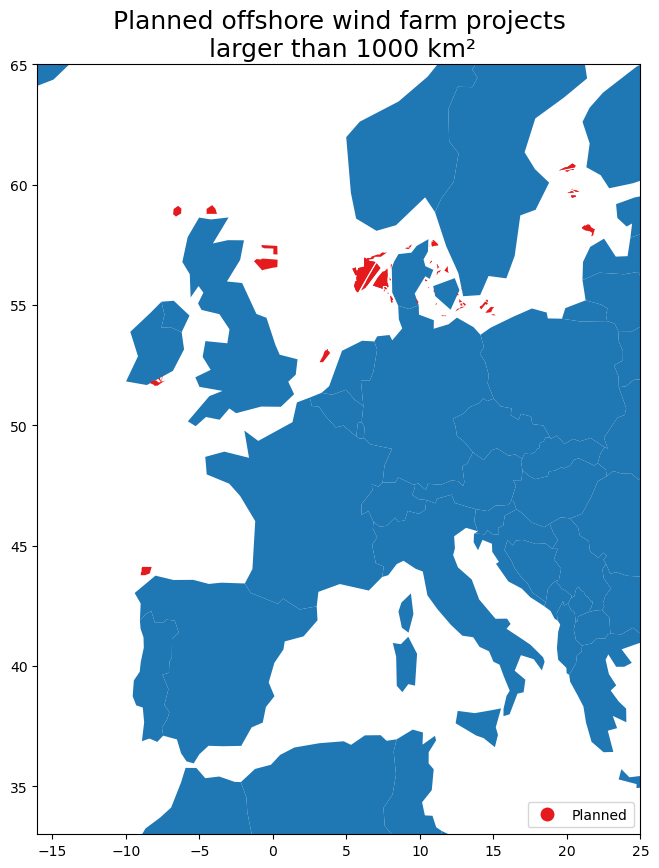

In [125]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(1, figsize=(8,10))
world.plot(ax=ax) # add world base layer

#Plot the dataset
gdf.plot(column='status',
         categorical=False,
         cmap='Set1',
         legend= True,
         legend_kwds={'loc': 'lower right'},
         alpha = 1,
         ax=ax)
ax.set_title('Planned offshore wind farm projects\n larger than 1000 km²',fontsize=18)

#Set the map limits based on the bbox params to zoom in on your dataset
ax.set_xlim(-16,25)
ax.set_ylim(33,65)

We will download the outline of the MissionAtlantic Study Area: Vitória-Trindade Seamount Chain off Brazil as we will use it for the rest of this tutorial

In [126]:
#dataset = 'geonode:Wind_Farms_EMODnet'
#print(wfs.contents[dataset].title)
#print(wfs.contents[dataset].abstract)
#response = wfs.getfeature(typename=dataset,
#                            outputFormat='application/json')
# write it to a GeoJson file
#with open(f'data/study_area.json', 'wb') as outfile:
#    outfile.write(response.read())
#response.close()
# read it into geopandas
#study_area = gpd.read_file('data/study_area.json')
#study_area.plot()

### 3.2 Get raster data with WCS

#### <i>Create a WebCoverageService (WCS) object</i>

In [127]:
wcs = WebCoverageService('https://geonode.missionatlantic.eu/geoserver/ows', version = '1.0.0')

#### <i>Get a list of available coverages</i>

In [128]:
for coverage_name in wcs.contents.keys():
    print(coverage_name)

geonode:AAHA_Level1_allClasses
geonode:AAHA_Level2_allClasses
geonode:AAHA_Level3_allClasses
geonode:AcaArc_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic
geonode:DisLop_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:Kstelliferun_density_clipped_GHO_reprojectedGeoNode
geonode:LophReef_threhsolded_GHO_reprojectedGeoNode
geonode:N1_p
geonode:N3_n
geonode:N5_s
geonode:O2_o
geonode:O3_TA
geonode:O3_c
geonode:PherCarp_threhsolded_GHO_reprojectedGeoNode
geonode:Ptot_Chl_result
geonode:Ptot_Chl_result_depth_int
geonode:Ptot_NPP_result
geonode:Ptot_NPP_result_depth_int
geonode:SyrFra_Ens_Cont_Preds_Thresh_200m_GHO_Masked_reprojectedGeoNode
geonode:mldr10_1
geonode:so_abs
geonode:thetao_con
geonode:uop_xenos_density


In [129]:
dataset = 'geonode:Atl_Combine_ExtendedBG_WMS_YoolProd_TopoFromMOL_10km_WGS84_atlantic'

#### <i>Retrieve a list of available properties of a coverage</i>

In [130]:
for item in dir(wcs.contents[dataset]):
    if "_" not in item:
        print(item)

abstract
axisDescriptions
boundingBox
boundingBoxWGS84
boundingboxes
crsOptions
defaulttimeposition
grid
id
keywords
styles
supportedCRS
supportedFormats
timelimits
timepositions
title


#### <i>Retrieve grid property information</i>

In [131]:
for item in dir(wcs.contents[dataset].grid):
    if "_" not in item:
        print(item + ": " + str(wcs.contents[dataset].grid.__dict__[item]))

axislabels: ['x', 'y']
dimension: 2
highlimits: ['1147', '1746']
lowlimits: ['0', '0']
offsetvectors: [['0.0833333333333333', '0.0'], ['0.0', '-0.0833333333333333']]
origin: ['-65.95833333333336', '83.29166666666667']


#### Get geo-bounding boxes and native CRS

In [132]:
wcs.contents[dataset].boundingBoxWGS84

(-66.00000000000003, -62.24999999999994, 29.6666666666666, 83.33333333333334)

#### Retrieve supported formats

In [133]:
wcs.contents[dataset].supportedFormats

['ArcGrid',
 'GeoTIFF',
 'GIF',
 'GeoPackage (mosaic)',
 'ImageMosaic',
 'JPEG',
 'MBTiles',
 'NetCDF',
 'PNG',
 'TIFF',
 'org.geoserver.catalog.testreader.CustomFormat']

#### Subset and download raster data using a GetCoverage request

##### Define a Study area
In this example, we will be looking to subset the "Non-Hierarchical habitat classification in the Atlantic Ocean in 2016" dataset obtained above to the marine region of the greater North sea.

In [134]:
# Connect to the MarineRegions.org WebFeatureService
wfs2 = WebFeatureService('https://geo.vliz.be/geoserver/MarineRegions/wfs', version= '1.0.0')

print(wfs2.identification.type)
print(wfs2.identification.version)
print(wfs2.identification.title)
print(wfs2.identification.abstract)
list(wfs2.contents)

WFS
1.0.0
Flanders Marine Institute (VLIZ) - WFS Service
This is the reference implementation of OGC WFS 1.0.0 and WFS 1.1.0, supports all WFS operations including Transaction.


['MarineRegions:eez_archipelagic_waters',
 'MarineRegions:arcticmarineareas',
 'MarineRegions:brasdorlakebiospherereserve',
 'MarineRegions:isa_ccz_managementarea',
 'MarineRegions:coasts_subnational',
 'MarineRegions:coasts_per_ocean',
 'MarineRegions:eez_24nm',
 'MarineRegions:comarge',
 'MarineRegions:cross_dateline_polygons',
 'MarineRegions:eca_reg13_nox',
 'MarineRegions:eca_reg14_sox_pm',
 'MarineRegions:eez',
 'MarineRegions:ecs',
 'MarineRegions:ecs_boundaries',
 'MarineRegions:fadaregions',
 'MarineRegions:fao',
 'MarineRegions:tnc_wwf_feow_hydrosheds',
 'MarineRegions:gsas_mediterraneanfishingzones',
 'MarineRegions:longhurst',
 'MarineRegions:goas',
 'MarineRegions:haedatgrids_polygon',
 'MarineRegions:high_seas',
 'MarineRegions:ices_ecoregions',
 'MarineRegions:ices_areas',
 'MarineRegions:ices_statistical_rectangles',
 'MarineRegions:iho',
 'MarineRegions:iho_quadrants_20150810',
 'MarineRegions:eez_internal_waters',
 'MarineRegions:itmarbiogeogsector_bianchi',
 'MarineR

In [151]:
dataset2 = 'MarineRegions:lme'

In [152]:
print(wfs2.contents[dataset2].title)
print(wfs2.contents[dataset2].abstract)
bbox2 = wfs2.contents[dataset2].boundingBoxWGS84
print(bbox2)


KeyError: <owslib.feature.wfs100.ContentMetadata object at 0x0000024A5FA07010>

In [137]:
wfs2.get_schema(dataset2)

{'properties': {'objectid': 'long',
  'lme_name': 'string',
  'grouping': 'string',
  'arctic': 'string',
  'uslmes': 'string',
  'shape_leng': 'decimal',
  'shape_area': 'decimal',
  'sum_gis_km': 'decimal',
  'mrgid': 'long',
  'minlat': 'double',
  'minlong': 'double',
  'maxlat': 'double',
  'maxlong': 'double',
  'lat': 'double',
  'lon': 'double',
  'lme_number': 'long'},
 'required': [],
 'geometry': 'MultiPolygon',
 'geometry_column': 'the_geom'}

In [138]:
# Read the GeoJson file using GeoPandas
gdf = gpd.read_file('data/lme.zip')
gdf

bboxNS = [gdf[3]

,objectid,lme_name,grouping,arctic,uslmes,shape_leng,shape_area,sum_gis_km,mrgid,minlat,minlong,maxlat,maxlong,lat,lon,lme_number,geometry
0,3.0,North Sea,NaN,NaN,NaN,209.486403,103.965247,693847.221941,8542.0,50.9672,-5.35678,62.00672,12.9375,57.37568,2.72626,22.0,"POLYGON ((5.27889 61.98027, 5.24917 61.97388, ..."


In [147]:
#Import the Filter encoding standard
import owslib.fes as fes 
from owslib.etree import etree

# Build a filter
filter = fes.PropertyIsEqualTo(propertyname='lme_name', literal='North Sea') # Planned Windfarm projects

# Get an xml representation of the filter
filterxml = etree.tostring(filter.toXML()).decode("utf-8")

# Pass it to getFeature
response = wfs2.getfeature(typename = Dataset,
                        outputFormat='application/json',
                        filter=filterxml)

# Write it to a GeoJson file
with open(f'data/{Dataset.replace(":","_")}_filtered.json', 'wb') as outfile:
    outfile.write(response.read())
response.close()

# Read the GeoJson file using GeoPandas
gdf = gpd.read_file(f'data/{Dataset.replace(":","_")}_filtered.json')
gdf


ServiceException: Feature type :M unknown

In [ ]:
# get parameters for grid
bbox = gdf.bounds.values[10].tolist() # get bbox for MissionAtlantic study area 
crs = gdf.crs.srs # get crs of the Study Area file
print(bbox)
print(crs)

In [ ]:
# GetCoverage request
response = wcs.getCoverage(identifier=dataset,
                           format='GeoTIFF',
                           bbox=bbox,
                           crs=crs,
                           resx=0.00833333,resy=0.00833333,
                           interpolation='bicubic')
print(response.geturl())
with open(f'data/{dataset.replace(":","_")}.tif','wb') as outfile:
    outfile.write(response.read())

#### Open rasterdata in an xarray object using the rasterio library

In [ ]:
import rioxarray
rasterdata = rioxarray.open_rasterio(f'data/{dataset.replace(":","_")}.tif')
rasterdata

#### Plot a map of the rasterdata overlaid with the study area

C:\Users\matteo.mikos\AppData\Local\Temp\ipykernel_10556\2873568182.py:7: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend()


Text(0.5, 1.0, 'Lophelia pertusa Habitat suitability in the study area')

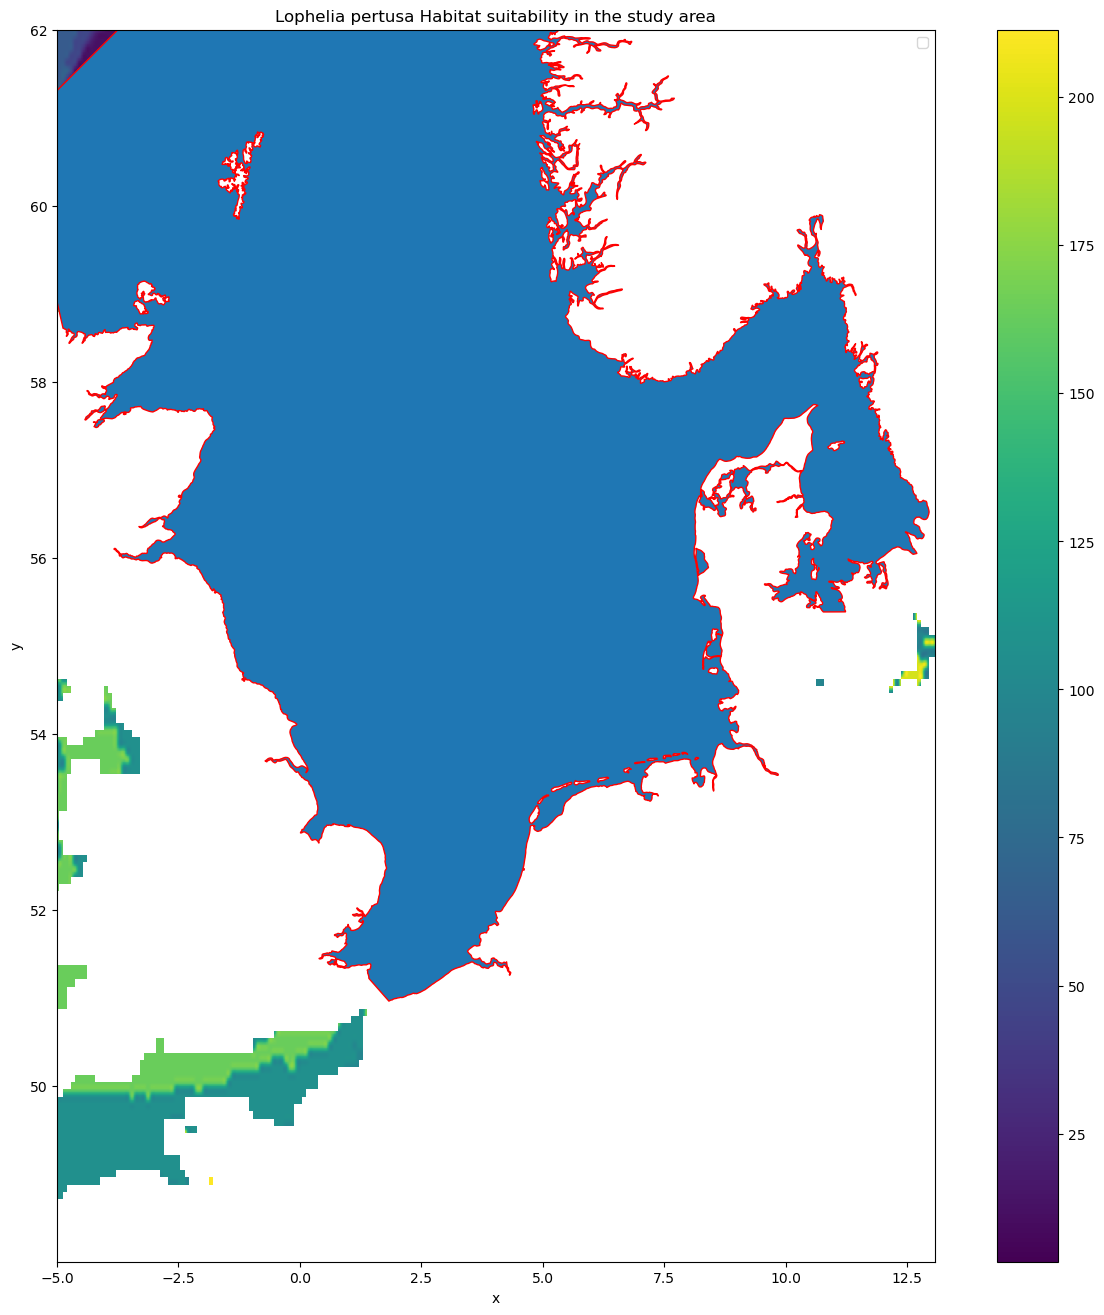

In [ ]:
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(111)
rasterdata.plot(ax = ax, cmap = 'viridis')#cbar_kwargs={'orientation': 'horizontal','label':'Habitat Suitability Index'} ) # plot raster data
gdf.plot(ax=ax, color=None, edgecolor = 'red', label = 'Study Area') # plot study areas
ax.legend()
ax.set_title('Lophelia pertusa Habitat suitability in the study area')

### [>> Next: Use OGC services from common GIS software](./4_OGC_services_from_common_GIS_software.ipynb)

<hr>

<a rel="license" href="http://creativecommons.org/licenses/by/4.0/"><img style="float: right" alt="Creative Commons Lizenzvertrag" style="border-width:0" src="https://i.creativecommons.org/l/by/4.0/88x31.png" /></a>